Author: Ahmed Sobhi

Creation_date: 25th Jul 2023

Objective: Data Modeling

# Importing required libararies and packages

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os

import pandas as pd
import numpy as np

# Used for visulization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid")

# For iteration visulization purpose
from tqdm import tqdm

# Import defined tools script
import sys

# adding tools script into system path
# sys.path.insert(0, '')
from tools import featureengineering, datapreprocessing, pipelinetransformers

# Used for datasplitting, modeling
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# To save the model locally
import joblib

# Data loading

In [3]:
# Loading raw dataset
df_raw = pd.read_csv('../data/raw/full_gen_data.csv')

df_raw.head()

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2,customer_id,...,style,sizes,gender,rgb_r_main_col,rgb_g_main_col,rgb_b_main_col,rgb_r_sec_col,rgb_g_sec_col,rgb_b_sec_col,label
0,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1003.0,...,slim,"xxs,xs,s,m,l,xl,xxl",women,205,104,57,255,187,255,0
1,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1003.0,...,regular,"xxs,xs,s,m,l,xl,xxl",women,188,238,104,255,187,255,0
2,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1003.0,...,regular,"xxs,xs,s,m,l,xl,xxl",women,205,173,0,255,187,255,0
3,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1003.0,...,regular,"xxs,xs,s,m,l,xl,xxl",kids,205,140,149,164,211,238,0
4,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1003.0,...,regular,"xxs,xs,s,m,l,xl,xxl",women,138,43,226,164,211,238,0


In [3]:
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
sales,100000.0,56.781800,87.934743,1.000000,10.000000,26.000000,64.000000,898.00
regular_price,100000.0,52.391200,35.272128,3.950000,25.950000,40.950000,79.950000,197.95
current_price,100000.0,28.290800,22.578343,1.950000,11.950000,20.950000,37.950000,195.95
ratio,100000.0,0.545646,0.194363,0.296482,0.354839,0.525044,0.699248,1.00
promo1,100000.0,0.061900,0.240975,0.000000,0.000000,0.000000,0.000000,1.00
promo2,100000.0,0.004900,0.069829,0.000000,0.000000,0.000000,0.000000,1.00
customer_id,100000.0,2721.726500,1908.085499,1.000000,1017.000000,2091.000000,4570.250000,5999.00
cost,100000.0,6.517000,3.914728,1.290000,2.290000,6.950000,9.600000,13.29
rgb_r_main_col,100000.0,161.400000,39.790147,79.000000,138.000000,160.000000,205.000000,205.00
rgb_g_main_col,100000.0,139.600000,63.641814,26.000000,104.000000,144.000000,181.000000,238.00


# Train Test split

In [4]:
target_col = 'label'
stratify_col = 'country'

# Select features only
df_features = df_raw.drop(target_col, axis=1)

df_y = df_raw[target_col]

x_temp, x_test, y_temp, y_test = train_test_split(
    df_features,
    df_y,
    test_size=0.2,
    random_state=42,
    stratify=df_features[stratify_col]
)

df_temp = pd.concat([x_temp, y_temp], axis=1)

# Apply data preprocessing
df_temp = datapreprocessing.data_preprocess(df_temp)

# Feature engineering
df_temp = featureengineering.feature_engineereing(df_temp)

x_temp = df_temp.drop(target_col, axis=1)
y_temp = df_temp[target_col]

x_train, x_val, y_train, y_val = train_test_split(
    x_temp,
    y_temp,
    test_size=0.2,
    random_state=42,
    stratify=x_temp[stratify_col]
)

In [5]:
# Diplay shapes
print('Train set shape:', x_train.shape, y_train.shape)
print('Validation set shape:', x_val.shape, y_val.shape)
print('Test set shape:', x_test.shape, y_test.shape)

Train set shape: (55436, 21) (55436,)
Validation set shape: (13859, 21) (13859,)
Test set shape: (20000, 23) (20000,)


# Preprocessing and Features Engineering

# Pipeline Steps

In [6]:
# Extract numerical|Categorical features
numeric_features = x_train.select_dtypes('number').columns.tolist()

categorical_features = x_train.select_dtypes('object').columns.tolist()

skewness_transformer = pipelinetransformers.SkewnessTransformer()

imputer_numeric = SimpleImputer(strategy='mean')
imputer_categorical = SimpleImputer(strategy='most_frequent')

numeric_transformer = Pipeline(
    [
        ('skewness', skewness_transformer),
        ('impute', imputer_numeric),
        ('scaler', StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    [
        ('impute', imputer_categorical),
        ('ohc', OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessor = ColumnTransformer(
    [
        ('numericals', numeric_transformer, numeric_features),
        ('Categorical', categorical_transformer, categorical_features)
    ],
    remainder='drop',
    n_jobs=-1
)

In [9]:
# # # Testing
# preprocessor.fit(x_train)

# preprocessor.transform(x_train)

# Model Pipeline

In [10]:
initial_lr = 0.05

model = XGBClassifier(objective='binary:logistic',
                     colsample_bytree=0.5,
                     learning_rate=initial_lr,
                     max_depth=6,
                     min_child_weight=1,
                     n_estimators=1000,
                     subsample=0.99,
                     verbosity=1,
                     n_jobs=-1)

XGB_param_grid = {
    'n_estimators': [500],
    'max_depth': [5],
    'learning_rate': [0.01],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

grid_model = pipelinetransformers.GridSearchModel(model, XGB_param_grid)

model_pipeline = Pipeline(
    steps=[
        ('col_trans', preprocessor),
        ('model', model)
    ]
)

In [11]:
model_pipeline.fit(x_train, y_train) 

/home/yousri/Workspace/fixedSolutions_ds_assessment/nb_workspace/tools/pipelinetransformers.py:62: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_vals = np.abs(stats.skew(X, axis=0))


{'No Fix': [0, 2, 3, 4]}


Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('numericals',
                                                  Pipeline(steps=[('skewness',
                                                                   SkewnessTransformer()),
                                                                  ('impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['sales', 'regular_price',
                                                   'current_price',
                                                   'promo_media_ads',
                                                   'promo_store_event',
                                                   'cost_article_2', 'discount',
                                                   'year', 'month', 'day',
                                                   'dayofweek']),
                                                 ('Categorical',...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               n_estimators=1000, n_jobs=-1,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

# Saving the model

In [12]:
# Save the model
if not os.path.exists('../src/model/'):
        os.makedirs('../src/model/')

joblib.dump(model_pipeline, f'../src/model/xgboost_model.pkl')

['../src/model/xgboost_model.pkl']

# Loading the model

In [13]:
# Load the model
model_load = joblib.load(f'../src/model/xgboost_model.pkl')

# Evaulating: Validation set

In [14]:
pred_train = model_load.predict(x_train)

pred_val = model_load.predict(x_val)

In [16]:
acc_train = accuracy_score(y_train, pred_train)

acc_val = accuracy_score(y_val, pred_val)

print(f"ACC:\n\tTrain Set = {acc_train}\n\tVal Set = {acc_val}")

ACC:
	Train Set = 0.8767587849051158
	Val Set = 0.8588642759217837


In [24]:
acc_x_train = pd.DataFrame({
    'y_true':y_train,
    'y_hat': pred_train
})

acc_x_val = pd.DataFrame({
    'y_true':y_val,
    'y_hat': pred_val
})

display(acc_x_train.describe().T)
display(acc_x_val.describe().T)

,count,mean,std,min,25%,50%,75%,max
y_true,55436.0,0.140089,0.347083,0.0,0.0,0.0,0.0,1.0
y_hat,55436.0,0.027239,0.162779,0.0,0.0,0.0,0.0,1.0


,count,mean,std,min,25%,50%,75%,max
y_true,13859.0,0.138466,0.345401,0.0,0.0,0.0,0.0,1.0
y_hat,13859.0,0.026337,0.160140,0.0,0.0,0.0,0.0,1.0


## Confusion Matrix

In [29]:
conf_matrix_train = confusion_matrix(y_train, pred_train)
conf_matrix_train

array([[47382,   288],
       [ 6544,  1222]])

In [33]:
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93     47670
           1       0.81      0.16      0.26      7766

    accuracy                           0.88     55436
   macro avg       0.84      0.58      0.60     55436
weighted avg       0.87      0.88      0.84     55436



In [28]:
conf_matrix_val = confusion_matrix(y_val, pred_val)
conf_matrix_val

array([[11739,   201],
       [ 1755,   164]])

In [32]:
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92     11940
           1       0.45      0.09      0.14      1919

    accuracy                           0.86     13859
   macro avg       0.66      0.53      0.53     13859
weighted avg       0.81      0.86      0.82     13859



This model has high precision, but Low Recall in case of detecting the Postive values.

# Feature Importance

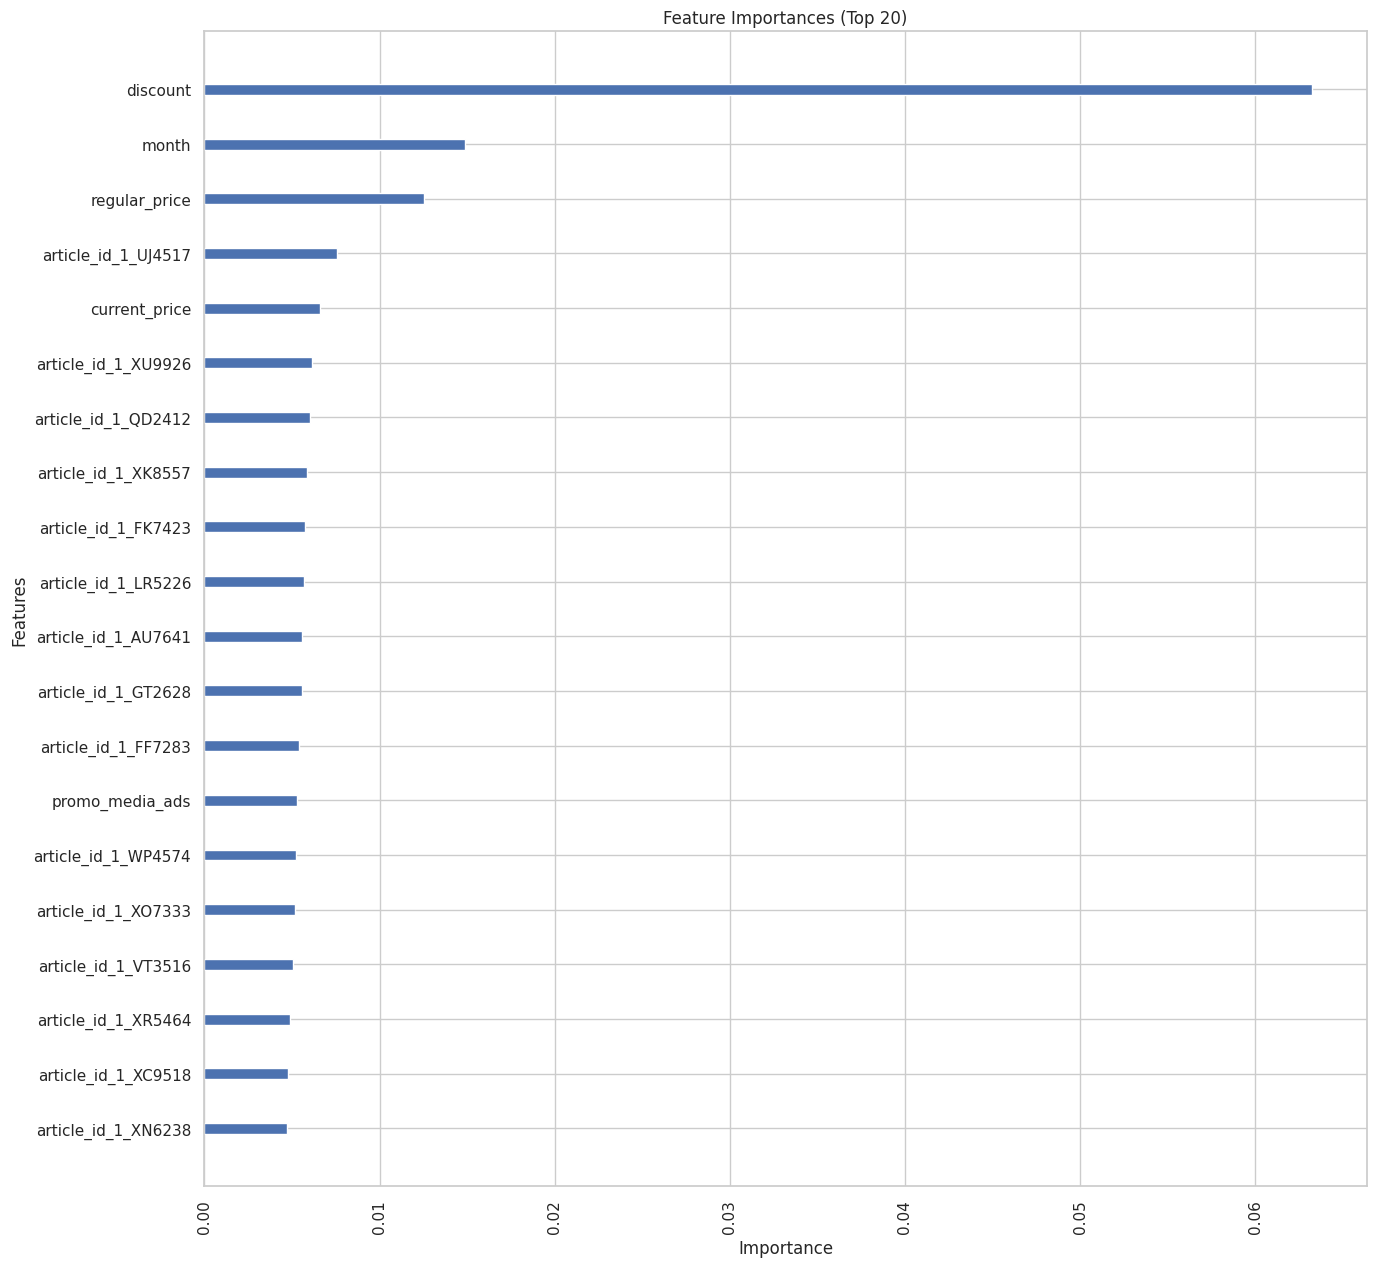

In [34]:
# Get features importances
features_importances = model_load.named_steps['model'].feature_importances_

# Get the ColumnTransformer step
column_transformer = model_load.named_steps['col_trans']

# Get the numerical feature names
numerical_features = column_transformer.transformers_[0][2]

# Get the one-hot encoded feature names
one_hot_encoder = column_transformer.named_transformers_['Categorical'].named_steps['ohc']
categorical_features = one_hot_encoder.get_feature_names_out(column_transformer.transformers_[1][2])

# Combine feature names and importances
feature_names = np.concatenate((numerical_features, categorical_features))
importances = np.concatenate((features_importances[:len(numerical_features)], features_importances[len(numerical_features):]))

importances, feature_names = zip(*sorted(zip(importances, feature_names)))

# Plot the feature importances
plt.figure(figsize=(15, 15))
plt.barh(feature_names[-20:], importances[-20:], height=0.2)
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Feature Importances (Top 20)')
plt.xticks(rotation=90)
plt.savefig('../report/plots/feature_importance_v0.png', bbox_inches='tight')
plt.show()

In [35]:
df_features_import = pd.DataFrame({'feature':feature_names, 'importance':importances})
df_features_import = df_features_import.sort_values('importance', ascending=False)
df_features_import.head(20)

,feature,importance
531,discount,0.063212
530,month,0.014862
529,regular_price,0.012556
528,article_id_1_UJ4517,0.007574
527,current_price,0.006620
526,article_id_1_XU9926,0.006131
525,article_id_1_QD2412,0.006002
524,article_id_1_XK8557,0.005846
523,article_id_1_FK7423,0.005762
522,article_id_1_LR5226,0.005703


In [36]:
df_features_import.to_csv(f'../data/output/feature_importance.csv', index=False)